In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import lightgbm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import lightgbm as lgb

from tqdm import tqdm
import warnings

%matplotlib inline
warnings.filterwarnings(action = 'ignore')
pd.set_option('display.max_columns', 500)

In [2]:
def split_y(data, col) :
    X = data.iloc[:, :-4]
    y = data.iloc[:, -4:]
    
    y = y[col]
    
    data = pd.concat([X,y], axis=1)
    
    return data

# 1. Data load

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [36]:
train.describe()

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,740_src,750_src,760_src,770_src,780_src,790_src,800_src,810_src,820_src,830_src,840_src,850_src,860_src,870_src,880_src,890_src,900_src,910_src,920_src,930_src,940_src,950_src,960_src,970_src,980_src,990_src,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,750_dst,760_dst,770_dst,780_dst,790_dst,800_dst,810_dst,820_dst,830_dst,840_dst,850_dst,860_dst,870_dst,880_dst,890_dst,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst,hhb,hbo2,ca,na
count,10000.00000,10000.000000,1.000000e+04,1.000000e+04,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,1.000000e+04,10000.000000,10000.000000,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,1.000000e+04,10000.000000,1.000000e+04,10000.000000,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,17.568000,5.995673e-01,5.194900e-01,0.461369,4.057044e-01,0.344423,0.295512,0.256295,2.220097e-01,1.812349e-01,1.398597e-01,9.294482e-02,5.206553e-02,0.016097,5.175759e-03,-0.004201,-0.000024,4.549858e-03,8.339086e-03,1.094692e-02,0.019087,1.914513e-02,2.089355e-02,1.798364e-02,2.902960e-02,5.926792e-02,0.111348,0.161113,1.978653e-01,0.239691,0.276372,3.267980e-01,0.375329,4.215361e-01,0.478444,0.534382,8.389789e+02,6.324312e+02,405.468228,470.365138,256.378656,438.047115,267.799300,266.542475,242.663595,180.127718,174.256064,190.705861,79.815992,30.426707,19.696768,13.566045,15.195817,14.708024,15.548672,16.083008,19.790925,22.542194,23.851786,34.616944,44.753912,54.609475,54.521394,59.884682,55.630987,63.086914,107.025427,161.687780,108.491613,38.970729,27.285526,7.990686,4.009146,9.019226,3.042651
std,2886.89568,5.595847,1.276235e+00,1.079378e+00,0.934520,8.045805e-01,0.692248,0.608706,0.551375,5.093061e-01,4.867288e-01,4.817866e-01,4.844860e-01,4.912916e-01,0.497753,5.042855e-01,0.508990,0.514460,5.173593e-01,5.195146e-01,5.234846e-01,0.523774,5.222664e-01,5.143327e-01,5.088767e-01,4.961690e-01,4.891031e-01,0.489296,0.486763,4.917185e-01,0.525007,0.573461,6.463100e-01,0.736599,8.400913e-01,0.972677,1.112357,3.283972e+04,2.392960e+04,11433.962707,9469.567871,2723.070116,7170.813497,3901.884606,2565.286200,2768.952177,1656.150912,1693.787242,2001.084745,681.574538,233.016649,131.429608,81.775354,88.727476,83.729952,91.918295,100.567037,123.714402,135.178457,123.112274,195.907353,251.488537,290.479950,302.563854,347.937470,318.333007,361.631605,645.380302,1189.325032,644.796466,195.533919,137.132396,2.970818,0.997828,2.979453,1.881872
min,0.00000,10.000000,-2.433349e-01,-2.415563e-01,-0.239670,-2.361734e-01,-0.241899,-0.252859,-0.270745,-2.946033e-01,-3.439202e-01,-4.124331e-01,-4.961411e-01,-5.793506e-01,-0.655200,-7.037079e-01,-0.744182,-0.765387,-7.769174e-01,-7.820933e-01,-7.857137e-01,-0.769586,-7.530344e-01,-7.189638e-01,-6.883167e-01,-6.290037e-01,-5.568598e-01,-0.471543,-0.385046,-3.207369e-01,-0.280482,-0.256480,-2.376039e-01,-0.231658,-2.312583e-01,-0.236569,-0.235508,-6.545215e-05,-8.523125e-05,-0.000066,-0.000110,-0.000102,-0.000147,-0.000159,-0.000157,-0.000245,-0.000300,-0.000408,-0.000319,-0.000394,-0.000920,-0.002424,-0.002693,-0.003243,-0.003144,-0.002882,-0.002397,-0.002691,-0.002563,-0.002548,-0.001864,-0.000869,-0.000913,-0.000635,-0.000540,-0.0

In [4]:
train

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,740_src,750_src,760_src,770_src,780_src,790_src,800_src,810_src,820_src,830_src,840_src,850_src,860_src,870_src,880_src,890_src,900_src,910_src,920_src,930_src,940_src,950_src,960_src,970_src,980_src,990_src,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,750_dst,760_dst,770_dst,780_dst,790_dst,800_dst,810_dst,820_dst,830_dst,840_dst,850_dst,860_dst,870_dst,880_dst,890_dst,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst,hhb,hbo2,ca,na
0,0,25,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,0.96333,1.01541,0.99865,0.94373,0.84513,0.74023,0.68776,0.57697,0.51536,0.43508,0.36501,0.34935,0.30038,0.26992,0.23192,0.21998,0.19920,0.14493,0.13150,0.12442,0.10786,0.11984,0.09851,0.10965,0.07424,0.07777,0.05536,2.447758e-18,1.894578e-18,0.000000e+00,6.412913e-18,1.098559e-17,8.907142e-19,NaN,0.000000e+00,NaN,0.000000e+00,5.901745e-18,NaN,1.176812e-18,NaN,5.557492e-17,1.046498e-16,NaN,7.236748e-17,4.021610e-17,2.397489e-17,1.870153e-17,1.808920e-17,NaN,0.000000e+00,2.626216e-18,NaN,3.527371e-18,NaN,6.455564e-19,NaN,0.000000e+00,NaN,1.067504e-18,5.998949e-18,4.378513e-17,5.59,4.32,8.92,4.29
1,1,10,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,0.00000,0.01295,0.00000,0.01565,0.00000,0.00000,0.01285,0.01129,0.00359,0.00000,0.00000,0.00000,0.00000,0.00000,0.04466,0.10738,0.21646,0.41456,0.63716,0.84230,0.97480,0.99803,0.97146,0.87045,0.75330,0.63414,0.53699,0.000000e+00,0.000000e+00,0.000000e+00,1.995530e-10,1.025259e-10,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,1.151021e-10,4.318673e-10,2.753933e-10,0.000000e+00,8.138830e-10,6.522110e-10,NaN,2.732232e-10,NaN,7.663267e-11,NaN,1.389496e-10,1.472282e-09,1.450463e-09,1.225321e-09,2.647633e-09,NaN,5.233480e-09,1.264238e-08,1.343132e-08,6.112685e-09,2.130547e-09,NaN,9.710091e-09,NaN,0.00,2.83,7.25,4.64
2,2,25,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,0.25584,0.30445,0.38962,0.50472,0.56934,0.67742,0.79720,0.87593,0.92783,0.99498,0.98682,0.98988,0.95101,0.89853,0.79813,0.68262,0.58043,0.46222,0.39113,0.27879,0.19070,0.16603,0.11617,0.06744,0.02343,0.03926,0.03136,1.677445e-19,3.763590e-20,NaN,0.000000e+00,NaN,NaN,8.981651e-19,1.944683e-19,8.126907e-19,2.183200e-19,3.349335e-19,NaN,0.000000e+00,2.630961e-18,NaN,0.000000e+00,9.912979e-18,1.112747e-17,NaN,NaN,NaN,1.260239e-19,NaN,0.000000e+00,3.876159e-18,4.629125e-18,1.409413e-18,3.237480e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.329725e-18,NaN,10.64,3.00,8.40,5.16
3,3,10,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,0.79865,0.91482,0.95274,0.99391,1.00563,0.93165,0.84703,0.74997,0.67765,0.58432,0.50642,0.43087,0.35684,0.30786,0.27722,0.24119,0.20158,0.17876,0.15139,0.15656,0.13392,0.14247,0.10126,0.09928,0.09239,0.10523,0.06349,4.044975e-11,NaN,5.345363e-11,9.106886e-12,1.881458e-11,3.617201e-11,7.909656e-13,NaN,1.583839e-10,NaN,1.678049e-10,2.814419e-10,4.429321e-10,1.319956e-09,2.269806e-09,2.679164e-09,2.538200e-09,2.046841e-09,1.516820e-09,1.328007e-09,1.061359e-09,8.634016e-10,5.804951e-10,3.615067e-10,NaN,1.274876e-10,6.118947e-11,NaN,1.663888e-10,2.245998e-10,1.299511e-10,7.782625e-11,NaN,4.088921e-10,NaN,5.67,4.01,5.05,4.35
4,4,15,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,1.01564,1.00216,1.01190,1.00344,0.98365,1.01350,1.01649,0.98220,0.99091,0.99258,1.00175,0.98861,0.98270,1.00432,1.01434,1.01455,0.98861,0.98300,1.00616,0.99045,1.01321,1.01559,1.01072,0.99439,0.98597,0.99889,1.01412,4.784751e-14,NaN,0.000000e+00,1.153089e-13,0.000000e+00,0.000000e+00,1.056991e-13,0.000000e+00,0.000000e+00,2.666663e-14,1.493071e-14,NaN,0.000000e+00,1.200730e-13,2.648249e-13,NaN,4.392331e-13,2.831191e-13,4.557059e-13,1.326038e-13,1.864796e-13,1.419359e-13,1.765559e-13,1.593789e-13,NaN,0.000000e+00,NaN,1.537619e-14,4.996522e-14,1.457955e-13,8.769053e-14,NaN,1.330237e-13,NaN,NaN,11.9

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 76 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       10000 non-null  int64  
 1   rho      10000 non-null  int64  
 2   650_src  10000 non-null  float64
 3   660_src  10000 non-null  float64
 4   670_src  10000 non-null  float64
 5   680_src  10000 non-null  float64
 6   690_src  10000 non-null  float64
 7   700_src  10000 non-null  float64
 8   710_src  10000 non-null  float64
 9   720_src  10000 non-null  float64
 10  730_src  10000 non-null  float64
 11  740_src  10000 non-null  float64
 12  750_src  10000 non-null  float64
 13  760_src  10000 non-null  float64
 14  770_src  10000 non-null  float64
 15  780_src  10000 non-null  float64
 16  790_src  10000 non-null  float64
 17  800_src  10000 non-null  float64
 18  810_src  10000 non-null  float64
 19  820_src  10000 non-null  float64
 20  830_src  10000 non-null  float64
 21  840_src  1000

# 2. EDA

### Data scaling 

src data and dst data are tiny compared dependent data  
So do a scaling using robust scaler   
The reason of using robust scaler is in here  
https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf

In [6]:
#set dst columns
src_column = train.iloc[:,2:37].columns
dst_column = train.iloc[:,37:72].columns

#scaling using scikit learn's robust scaling
src_scaler = RobustScaler().fit(train[src_column])
src_scale = src_scaler.transform(train[src_column])

dst_scaler = RobustScaler().fit(train[dst_column])
dst_scale = dst_scaler.transform(train[dst_column])

#change the result to dataframe and replace train data
src_scale = pd.DataFrame(src_scale)
dst_scale = pd.DataFrame(dst_scale)

train[src_column] = src_scale
train[dst_column] = dst_scale

### Elimination null value

In [7]:
#check train data's null
train_column = train.columns
train_null_column = []

for col in train_column :
    null = train[col].isnull().sum()
    if null > 0 :
        print('null number of {0} column : {1}'.format(col, null))
        train_null_column.append(col)

null number of 650_dst column : 1948
null number of 660_dst column : 1988
null number of 670_dst column : 1931
null number of 680_dst column : 1975
null number of 690_dst column : 2003
null number of 700_dst column : 1966
null number of 710_dst column : 1946
null number of 720_dst column : 2046
null number of 730_dst column : 2006
null number of 740_dst column : 1993
null number of 750_dst column : 2071
null number of 760_dst column : 2050
null number of 770_dst column : 1994
null number of 780_dst column : 1945
null number of 790_dst column : 2059
null number of 800_dst column : 2026
null number of 810_dst column : 1990
null number of 820_dst column : 2091
null number of 830_dst column : 1965
null number of 840_dst column : 2045
null number of 850_dst column : 2014
null number of 860_dst column : 2010
null number of 870_dst column : 2020
null number of 880_dst column : 1968
null number of 890_dst column : 2059
null number of 900_dst column : 1999
null number of 910_dst column : 2030
n

In [8]:
#check test data's null
test_column = test.columns
test_null_column = []

for col in test_column :
    null = test[col].isnull().sum()
    if null > 0 :
        print('null number of {0} column : {1}'.format(col, null))
        test_null_column.append(col)

null number of 650_dst column : 2026
null number of 660_dst column : 1960
null number of 670_dst column : 2015
null number of 680_dst column : 2006
null number of 690_dst column : 1985
null number of 700_dst column : 1948
null number of 710_dst column : 2043
null number of 720_dst column : 2014
null number of 730_dst column : 2038
null number of 740_dst column : 1999
null number of 750_dst column : 1965
null number of 760_dst column : 2000
null number of 770_dst column : 1956
null number of 780_dst column : 2020
null number of 790_dst column : 2030
null number of 800_dst column : 1961
null number of 810_dst column : 2034
null number of 820_dst column : 2042
null number of 830_dst column : 2058
null number of 840_dst column : 1947
null number of 850_dst column : 2005
null number of 860_dst column : 2008
null number of 870_dst column : 2063
null number of 880_dst column : 2080
null number of 890_dst column : 1996
null number of 900_dst column : 1976
null number of 910_dst column : 1919
n

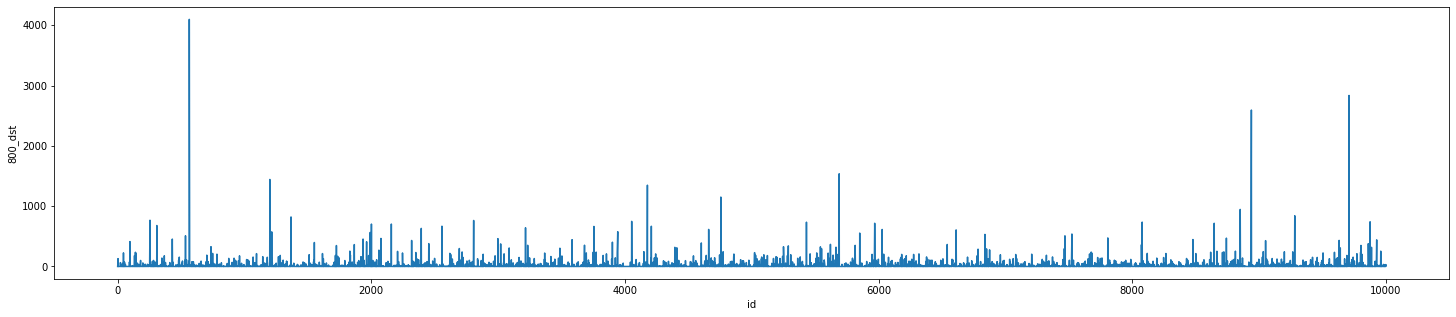

In [9]:
fig, ax = plt.subplots(figsize = (25, 5))

sns.lineplot(x = train['id'], y = train['800_dst'], ax = ax)
plt.show()

In [10]:
print('mean : {}'.format(train['650_dst'].mean()))
print('median : {}'.format(train['650_dst'].median()))
print('mode : {}'.format(train['650_dst'].mode()))

mean : 1041.9509177260513
median : 4.460157862885925e-21
mode : 0   -0.000065
dtype: float64


**Since zero appears most frequently, it is safe to replace all values with zero.**

In [11]:
#replace each column's null, as a median of column
for col in train_null_column :
    train[col].fillna(0, inplace = True)
    
for col in test_null_column :
    test[col].fillna(0, inplace = True)

### Calculate correlation between dependent variables and src&dst datas

In [12]:
src_column = list(src_column)
dst_column = list(dst_column)

for col in ['hhb', 'hbo2', 'ca', 'na'] : 
    src_column.append(col)
    dst_column.append(col)

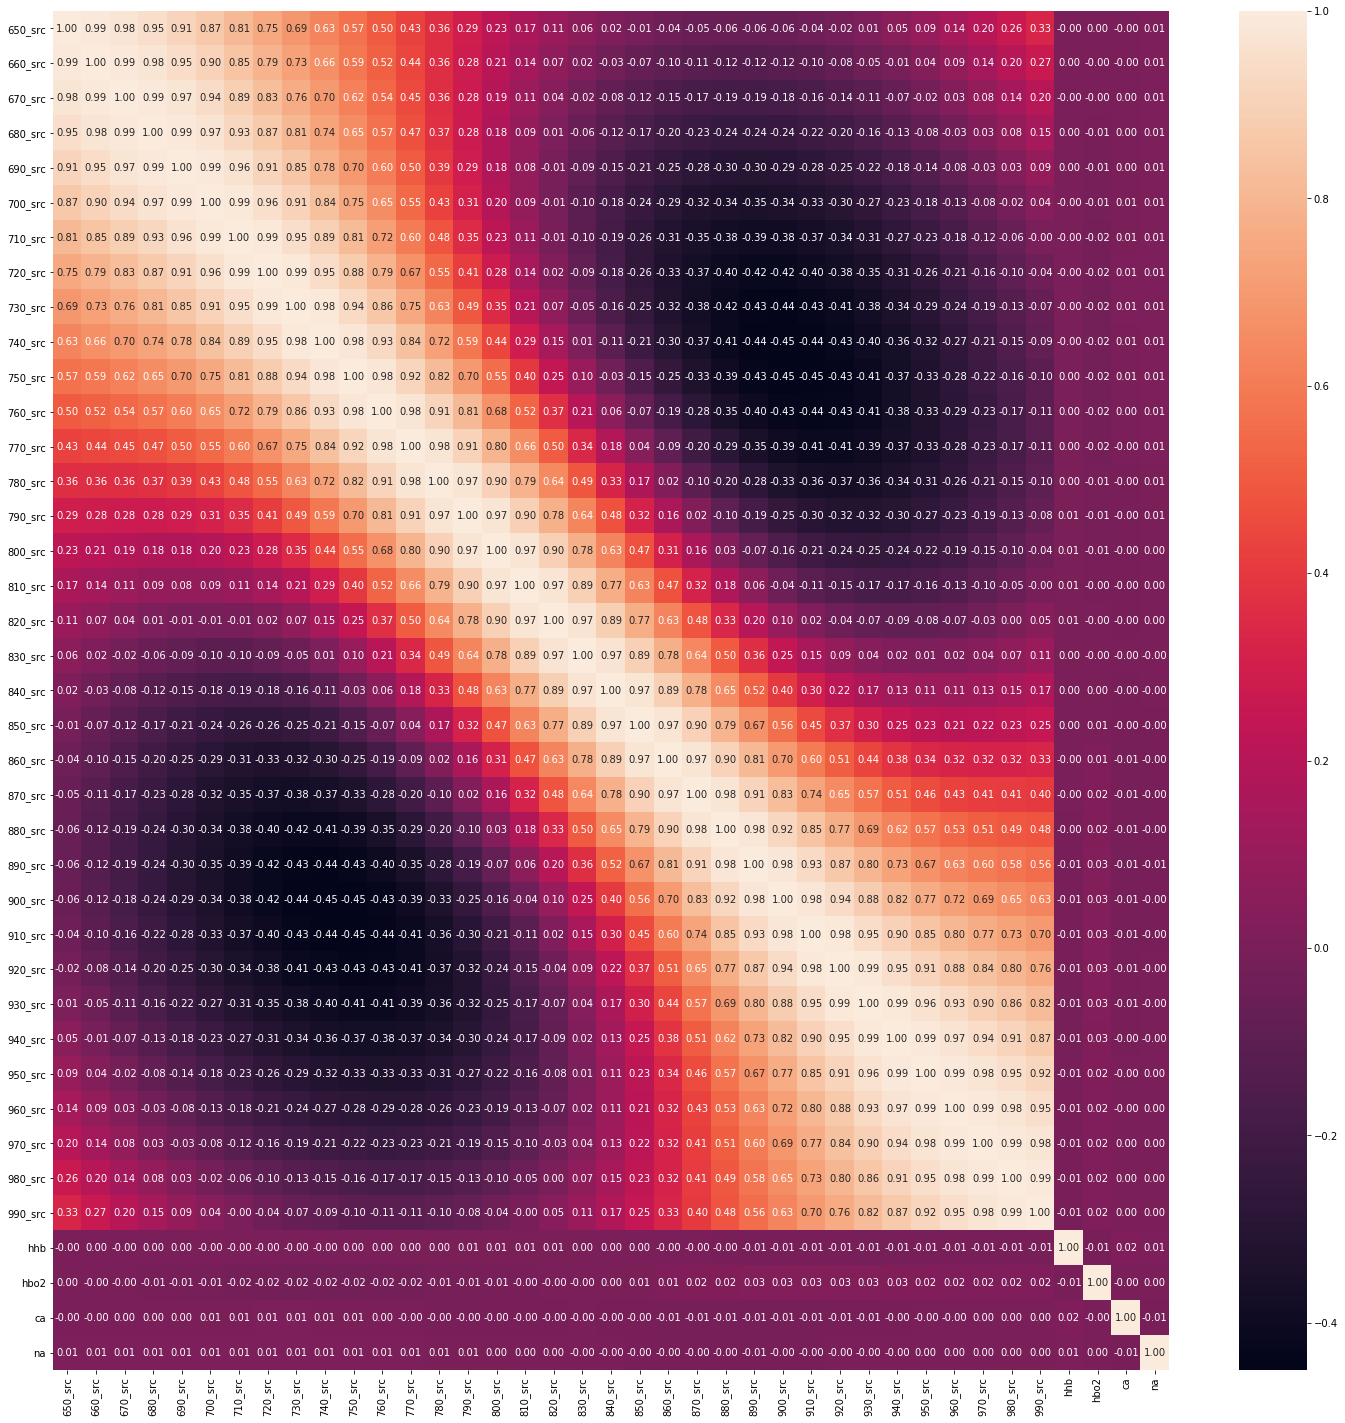

In [13]:
fig, ax = plt.subplots(figsize = (25, 25))

sns.heatmap(train[src_column].corr(), annot=True, fmt='.2f', ax=ax)
plt.show()

**dst 데이터와 종속변수간의 상관관계 파악**

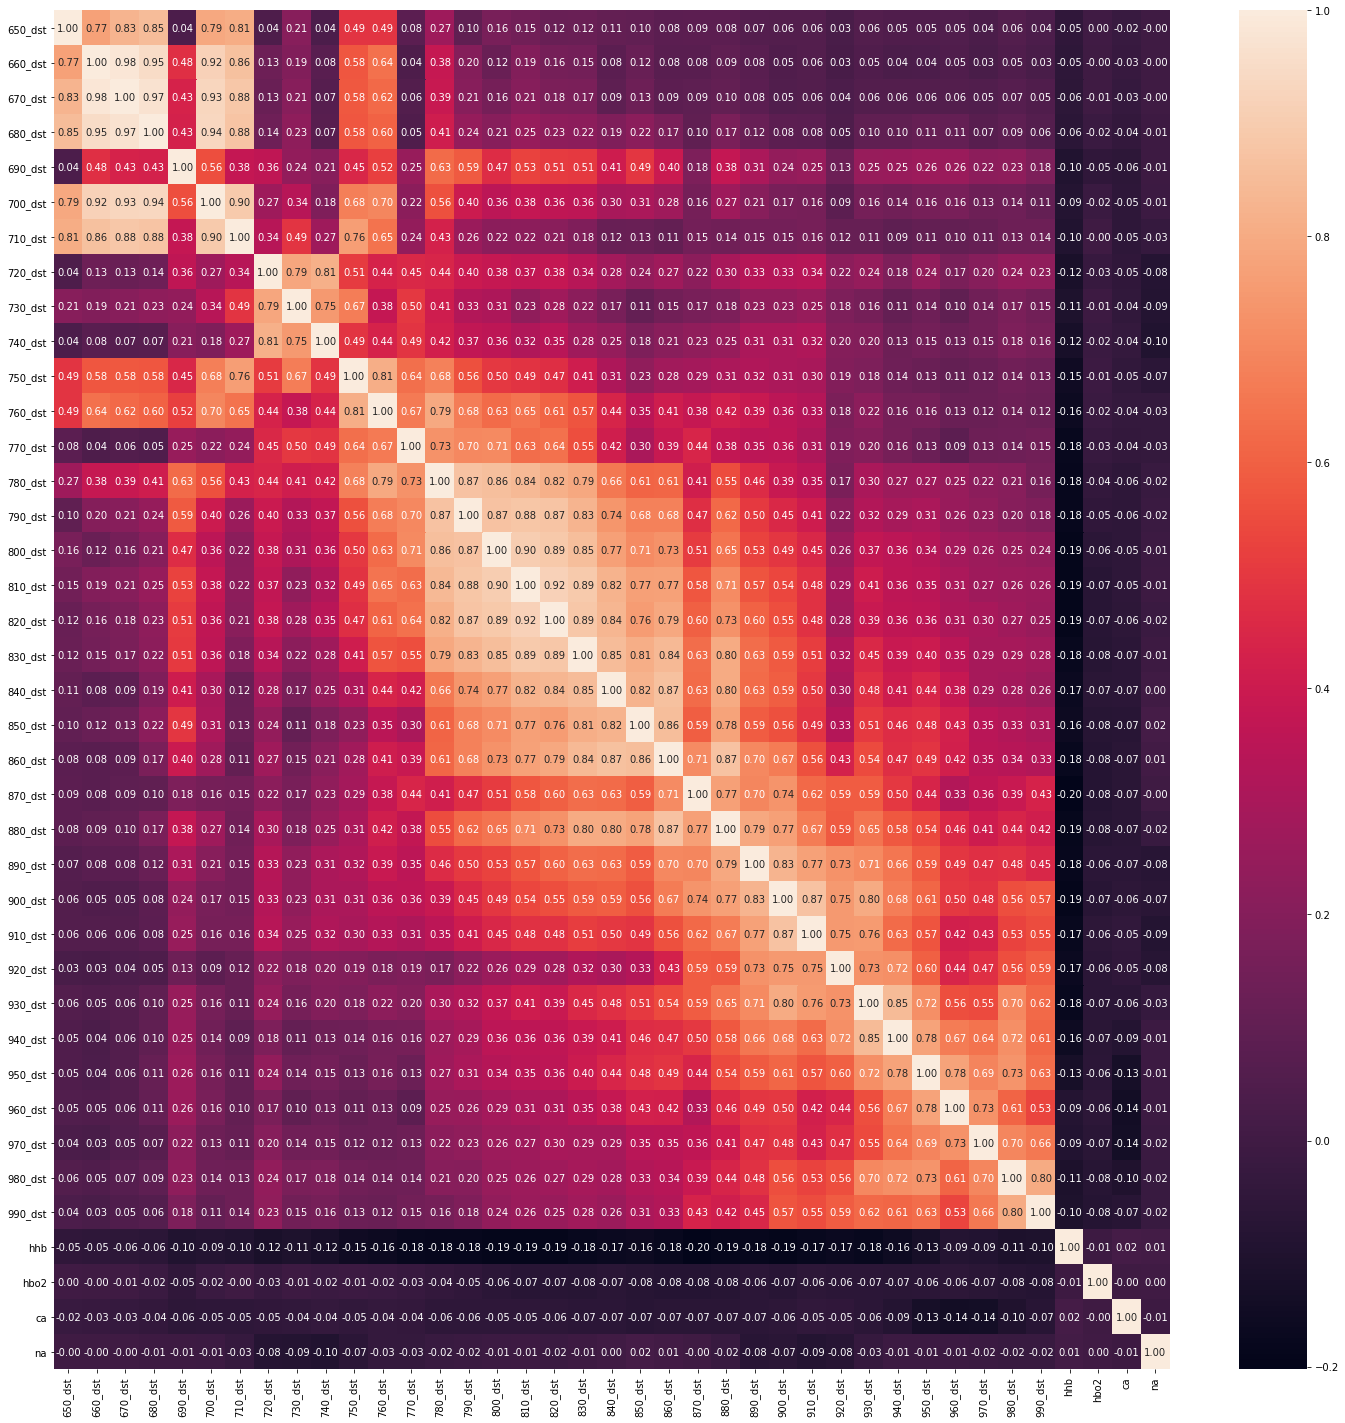

In [14]:
fig, ax = plt.subplots(figsize = (25, 25))

sns.heatmap(train[dst_column].corr(), annot=True, fmt='.2f', ax=ax)
plt.show()

# 3. Model

**Use random forest algorithm**

### Make model

In [15]:
train_hhb = split_y(train, 'hhb')
train_hbo2 = split_y(train, 'hbo2')
train_na = split_y(train, 'na')
train_ca = split_y(train, 'ca')

## hhb train

In [16]:
train_hhb.drop(['id'], axis=1, inplace=True)

In [17]:
#split train and test

X = train_hhb.iloc[:, :-1]
y = train_hhb.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [18]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

y_pred_train = pd.DataFrame(y_pred_train, columns = ['hhb'])
y_pred_test = pd.DataFrame(y_pred_test, columns = ['hhb'])

# for col in y_pred_train.columns :
print("train r-squared of {0} columns is {1} ".format('hhb', round(r2_score(y_train, y_pred_train), 2)))
print("test r-squared of {0} columns is {1} ".format('hhb', round(r2_score(y_test, y_pred_test), 2)))

train r-squared of hhb columns is 0.97 
test r-squared of hhb columns is 0.76 


## hbo2 train

In [19]:
train_hbo2.drop(['id'], axis=1, inplace=True)

In [20]:
#split train and test

X = train_hbo2.iloc[:, :-1]
y = train_hbo2.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [21]:
make_y2 = train_hbo2.iloc[:0, -1]

In [22]:
make_y2

Series([], Name: hbo2, dtype: float64)

In [23]:
make_xc = train_hbo2.iloc[:0, 1:-1]

In [34]:
train_hbo2.iloc[:, :-1]

,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,740_src,750_src,760_src,770_src,780_src,790_src,800_src,810_src,820_src,830_src,840_src,850_src,860_src,870_src,880_src,890_src,900_src,910_src,920_src,930_src,940_src,950_src,960_src,970_src,980_src,990_src,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,750_dst,760_dst,770_dst,780_dst,790_dst,800_dst,810_dst,820_dst,830_dst,840_dst,850_dst,860_dst,870_dst,880_dst,890_dst,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
0,25,1.531688,1.366064,1.348957,1.179703,1.129366,1.031533,0.973250,0.963339,0.882490,0.871348,0.788428,0.671008,0.497550,0.334956,0.244324,0.080576,-0.011664,-0.130522,-0.233492,-0.242606,-0.304178,-0.325905,-0.359174,-0.330226,-0.295090,-0.283843,-0.217118,-0.160281,-0.130269,-0.070271,-0.058895,0.006863,-0.035994,0.016116,-0.016681,0.000161,0.000057,-0.000066,0.000545,0.000502,-0.000097,0.000000,-0.000157,0.000000,-0.000300,-0.000369,0.000000,-0.000392,0.000000,-0.002419,-0.002688,0.000000,-0.003141,-0.002880,-0.002395,-0.002689,-0.002561,0.000000,-0.001864,-0.000868,0.000000,-0.000631,0.000000,-0.000938,0.000000,-0.000263,0.000000,-0.000413,-0.001417,-0.002468
1,10,-0.243335,-0.241556,-0.184363,-0.236173,-0.241899,-0.219267,-0.265968,-0.294603,-0.343920,-0.396060,-0.496141,-0.558616,-0.655200,-0.703708,-0.725713,-0.748833,-0.771587,-0.782093,-0.785714,-0.769586,-0.753034,-0.718964,-0.624935,-0.483160,-0.272408,0.065358,0.428618,0.765517,1.077084,1.294273,1.524738,1.661828,1.750054,1.823832,1.887108,-0.000065,-0.000085,-0.000066,20409.672860,5637.044768,-0.000147,-0.000159,-0.000157,0.000000,-0.000300,750.974914,2524.361011,418.728497,-0.000920,79.645280,31.633064,0.000000,14.758743,0.000000,6.569883,0.000000,16.931291,224.491420,488.352252,892.658306,2265.469543,0.000000,5885.905988,10324.453479,14133.224631,19180.723035,17252.021040,0.000000,4058.715567,0.000000
2,25,-0.243335,-0.118572,-0.165968,-0.146762,-0.123755,-0.099449,-0.048321,-0.044985,-0.018212,-0.027517,0.005029,0.089359,0.121375,0.246824,0.401620,0.518916,0.600809,0.707978,0.707240,0.723609,0.668054,0.589478,0.444397,0.298132,0.205888,0.127083,0.114433,0.038798,-0.014901,0.001499,-0.026858,-0.084956,-0.169633,-0.109008,-0.111548,-0.000050,-0.000082,0.000000,-0.000110,0.000000,0.000000,-0.000136,-0.000153,-0.000231,-0.000298,-0.000406,0.000000,-0.000394,-0.000919,0.000000,-0.002693,-0.003243,-0.003144,0.000000,0.000000,0.000000,-0.002563,0.000000,-0.001864,-0.000867,-0.000909,-0.000633,-0.000536,-0.000939,-0.000691,-0.000263,-0.000205,-0.000416,-0.001419,0.000000
3,10,1.043054,0.928122,0.763915,0.780322,0.700080,0.645123,0.687316,0.693794,0.672837,0.744172,0.729374,0.737492,0.716471,0.603550,0.473240,0.334231,0.229319,0.092978,-0.019554,-0.119636,-0.219811,-0.270657,-0.294883,-0.301419,-0.291962,-0.240029,-0.191719,-0.118833,-0.093977,-0.035108,-0.053906,-0.015695,0.011744,0.105337,0.015455,3746.776300,0.000000,3756.999530,931.424258,1034.456445,2012.400479,19.597496,0.000000,2568.123687,0.000000,1094.830926,1645.090760,673.467154,324.646594,222.123850,129.951223,128.678022,110.584973,103.017650,113.892050,117.930915,105.220598,88.511494,121.713241,0.000000,109.084964,61.903185,0.000000,135.881222,236.336462,407.767492,630.194897,0.000000,170.911221,0.000000
4,15,4.505075,3.530311,2.778283,2.212718,1.815929,1.476635,1.217777,1.025065,0.949086,0.854596,0.805472,0.750118,0.686490,0.718399,0.716801,0.674731,0.694476,0.704383,0.729827,0.721693,0.715408,0.743530,0.751244,0.748960,0.742280,0.801550,0.899837,0.956575,1.130576,1.321558,1.595960,1.931435,2.362018,3.008951,3.773109,4.431950,0.000000,-0.000066,11.793334,-0.000102,-0.000147,2.618734,-0.000157,-0.000245,0.308820,0.097007,0.000000,-0.000394,0.028612,0.023492,0.000000,0.019025,0.012152,0.028069,0.008976,0.018029,0.014734,0.024373,0.051797,0.000000,-0.000913,0.000000,0.016753,0.039866,0.152724,0.274897,0.000000,0.449144,0.000000,0.000000
...,...,...,...,.

In [25]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

y_pred_train = pd.DataFrame(y_pred_train, columns = ['hbo2'])
y_pred_test = pd.DataFrame(y_pred_test, columns = ['hbo2'])

# for col in y_pred_train.columns :
print("train r-squared:{}".format(round(r2_score(y_train, y_pred_train), 2)))
print("test r-squared:{}".format(round(r2_score(y_test, y_pred_test), 2)))

train r-squared:0.89
test r-squared:0.23


In [151]:
def create_model(train, val):
    params = {
        'metric': 'mae',
        'seed':7777
        }

    model = lgb.train(params, d_train, 1000, d_val, verbose_eval=1000, early_stopping_rounds=100)
    
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.plot(np.array(y_val), '.-', label='y_val')
    plt.plot(model.predict(x_val), '.-', label='y_pred')
    plt.title(str(future)+'days later')
    plt.legend()
    plt.show()

    return model

In [152]:
def trans(dataset, start_index, end_index, past, future, x_columns, y_columns):
    dataset.index = range(dataset.shape[0])
    data = []
    labels = []
    
    start_index = start_index + past
#     start_index = start_index + past
    
    if end_index is None:
        end_index = dataset.shape[0]
    
    for i in range(start_index, end_index-future):
        indices = np.array(dataset.loc[i-1:i, x_columns])
        data.append(indices)
        
        labels.append(np.array(dataset.loc[i+future, y_columns]))
        
    data = np.array(data)
    data = data.reshape(data.shape[0], -1)
    labels = np.array(labels)
    labels = labels.reshape(-1)
    
    return data, labels

In [153]:
i=1
np.array(train.loc[i-1:i, x_columns])

array([[ 0.00000000e+00, -4.12701966e-04, -1.41687054e-03],
       [ 1.72520210e+04,  0.00000000e+00,  4.05871557e+03]])

In [154]:
past=5000
x_columns = ['960_dst','970_dst','980_dst']
# x_columns = ['920_dst','950_dst','960_dst','970_dst','980_dst','990_dst','rho']
y_columns = ['hbo2']
supply_models = {}

In [155]:
x_columns

['960_dst', '970_dst', '980_dst']

In [156]:
x_train

array([[ 0.00000000e+00,  6.06864791e-04, -6.50556923e-04,
         0.00000000e+00, -4.16309654e-04, -1.41706370e-03],
       [ 0.00000000e+00, -4.16309654e-04, -1.41706370e-03,
        -2.04515958e-04, -4.14279749e-04, -1.41413307e-03],
       [-2.04515958e-04, -4.14279749e-04, -1.41413307e-03,
         6.74913949e-01,  0.00000000e+00,  4.67934257e-01],
       ...,
       [-2.04515958e-04,  9.22504018e-02,  1.02888023e-01,
         6.74398359e-01,  4.88243082e-01,  0.00000000e+00],
       [ 6.74398359e-01,  4.88243082e-01,  0.00000000e+00,
         8.68494551e+01,  4.35098466e+02,  1.27110616e+02],
       [ 8.68494551e+01,  4.35098466e+02,  1.27110616e+02,
         0.00000000e+00,  3.94292041e+00,  2.73075088e+00]])

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's l1: 0.110704
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.110704


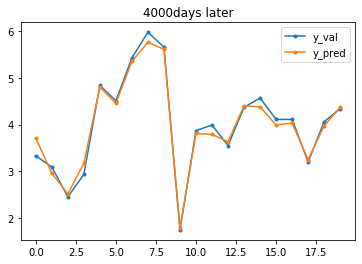

In [157]:
future = 4000
train_split = train.shape[0]-past-future-20 # 마지막 30일을 validation set으로 사용
x_train, y_train = trans(train, 0, 10000, 4000, future, x_columns, y_columns)
x_val, y_val = trans(train, train_split, None, past, future, x_columns, y_columns)

d_train = lgb.Dataset(x_train, y_train)
d_val = lgb.Dataset(x_val, y_val)

supply_models[future] = create_model(d_train, d_val)
print('==============================')

In [75]:
x_columns
y_columns

['hbo2']

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 0.88455


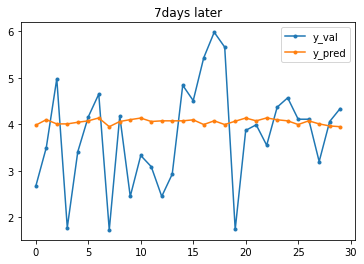

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's l1: 0.84587


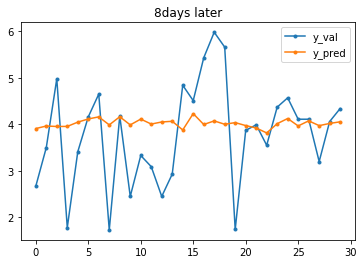

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's l1: 0.877037


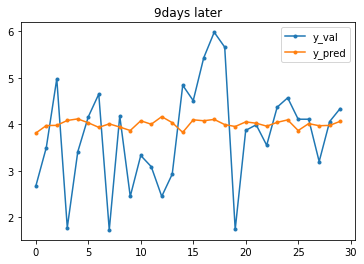

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's l1: 0.869715


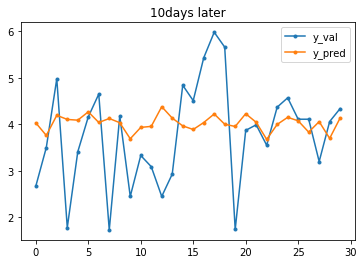

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[4]	valid_0's l1: 0.85577


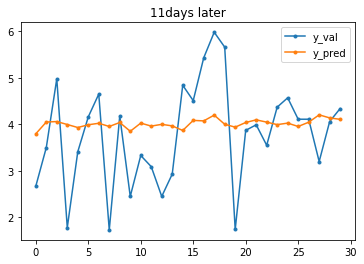

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 0.878563


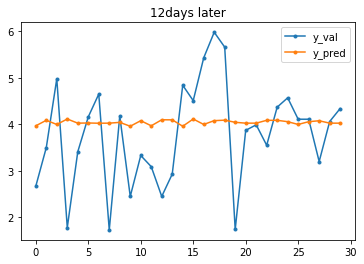

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 0.862242


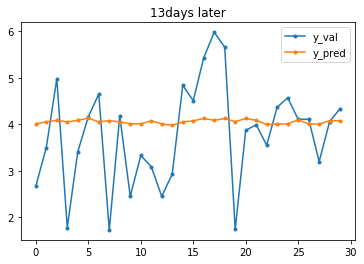

KeyboardInterrupt: 

In [73]:
for future in range(7, 35):
    train_split = train.shape[0]-past-future-30 # 마지막 30일을 validation set으로 사용
    x_train, y_train = trans(train, 0, train_split, past, future, x_columns, y_columns)
    x_val, y_val = trans(train, train_split, None, past, future, x_columns, y_columns)
    
    d_train = lgb.Dataset(x_train, y_train)
    d_val = lgb.Dataset(x_val, y_val)

    supply_models[future] = create_model(d_train, d_val)
    print('==========================================================================')

In [ ]:
X_train.head()

In [41]:
y_pred_test.head()

,ca
0,6.6982
1,8.4527
2,9.8514
3,9.0988
4,8.5284


## na train

In [29]:
train_na.drop(['id'], axis=1, inplace=True)

In [30]:
#split train and test

X = train_na.iloc[:, :-1]
y = train_na.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [31]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

y_pred_train = pd.DataFrame(y_pred_train, columns = ['na'])
y_pred_test = pd.DataFrame(y_pred_test, columns = ['na'])

# for col in y_pred_train.columns :
print("train r-squared:{}".format(round(r2_score(y_train, y_pred_train), 2)))
print("test r-squared:{}".format(round(r2_score(y_test, y_pred_test), 2)))

train r-squared:0.88
test r-squared:0.16


## ca train

In [32]:
train_ca.drop(['id'], axis=1, inplace=True)

In [33]:
#split train and test

X = train_ca.iloc[:, :-1]
y = train_ca.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [34]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

y_pred_train = pd.DataFrame(y_pred_train, columns = ['ca'])
y_pred_test = pd.DataFrame(y_pred_test, columns = ['ca'])

# for col in y_pred_train.columns :
print("train r-squared:{}".format(round(r2_score(y_train, y_pred_train), 2)))
print("test r-squared:{}".format(round(r2_score(y_test, y_pred_test), 2)))

train r-squared:0.9
test r-squared:0.27


**train에 비해 test의 performance가 너무 작음**  
**예측값을 높이기 위해 변수간 다중공선성을 줄여줌**

In [35]:
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [36]:
pd.set_option('display.max_rows', 500)
vif.round(1)

,VIF Factor,features
0,2.3,rho
1,291.3,650_src
2,643.5,660_src
3,732.4,670_src
4,755.7,680_src
5,792.3,690_src
6,768.3,700_src
7,753.3,710_src
8,771.9,720_src
9,718.2,730_src


**src column이 다중공선성이 높으므로 모두 drop**

In [102]:
#check feature importance
importance = rf.feature_importances_
x_columns = X.columns

importance = pd.Series(importance, index = x_columns)

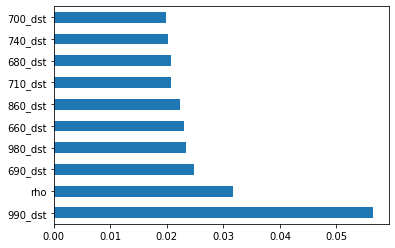

In [103]:
ax = importance.nlargest(10).plot.barh()

**src보다는 dst와 rho가 더 중요함**

In [108]:
x_columns

Index(['rho', '650_src', '660_src', '670_src', '680_src', '690_src', '700_src',
       '710_src', '720_src', '730_src', '740_src', '750_src', '760_src',
       '770_src', '780_src', '790_src', '800_src', '810_src', '820_src',
       '830_src', '840_src', '850_src', '860_src', '870_src', '880_src',
       '890_src', '900_src', '910_src', '920_src', '930_src', '940_src',
       '950_src', '960_src', '970_src', '980_src', '990_src', '650_dst',
       '660_dst', '670_dst', '680_dst', '690_dst', '700_dst', '710_dst',
       '720_dst', '730_dst', '740_dst', '750_dst', '760_dst', '770_dst',
       '780_dst', '790_dst', '800_dst', '810_dst', '820_dst', '830_dst',
       '840_dst', '850_dst', '860_dst', '870_dst', '880_dst', '890_dst',
       '900_dst', '910_dst', '920_dst', '930_dst', '940_dst', '950_dst',
       '960_dst', '970_dst', '980_dst', '990_dst'],
      dtype='object')